## Libraries

In [1]:
import os 
import numpy as np 
import pandas as pd
from scipy import stats

## Loading data

- The data comes from [NASDAQ](https://www.nasdaq.com/market-activity/index/spx/historical?page=1&rows_per_page=10&timeline=y10)

In [2]:
sp500 = pd.read_csv('sp500.csv')

In [3]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2525 non-null   object 
 1   Close/Last  2525 non-null   float64
 2   Open        2525 non-null   float64
 3   High        2525 non-null   float64
 4   Low         2525 non-null   float64
dtypes: float64(4), object(1)
memory usage: 98.8+ KB


In [4]:
sp500.Date = pd.to_datetime(sp500.Date)

<Axes: title={'center': 'S&P 500 Close Price'}, xlabel='Date'>

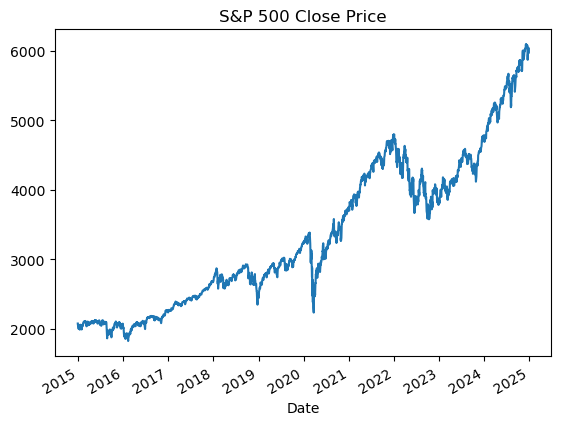

In [5]:
sp500.sort_values("Date").set_index('Date')["Close/Last"].plot(kind='line', title='S&P 500 Close Price')

In [6]:
sp500.head(3)

,Date,Close/Last,Open,High,Low
0,2024-12-27,5970.84,6006.17,6006.17,5932.95
1,2024-12-26,6037.59,6024.97,6049.75,6007.37
2,2024-12-24,6040.04,5984.63,6040.10,5981.44


## Data description

In [7]:
sp500.head(30)["Close/Last"].describe()

count      30.000000
mean     5998.206000
std        70.283469
min      5867.080000
25%      5948.825000
50%      6027.005000
75%      6050.970000
max      6090.270000
Name: Close/Last, dtype: float64

In [8]:
n_days = 30
conf_level = 0.99

## Normality test of the prices (Jarque-Bera)

In [9]:
# Perform Jarque-Bera test
jb_stat, p_value = stats.jarque_bera(sp500["Close/Last"].head(n_days))

# Check if the close prices are normally distributed
assert p_value > 1-conf_level, "The close prices are not normally distributed"


## D'Agostino and Pearson normality test

In [10]:
# Perform normality test
n_days = 30
k2, p_value = stats.normaltest( sp500["Close/Last"].head(n_days))

# Check if the close prices are normally distributed
assert p_value > 1-conf_level, "The close prices are not normally distributed"

## Simple Confidence Interval

In [11]:
stats.norm.interval(conf_level, loc=sp500["Close/Last"].head(n_days).mean(), scale=sp500["Close/Last"].head(n_days).std()/np.sqrt(n_days))

(5965.153094479969, 6031.2589055200315)

## One-tailed to see if the prices will go above 6100

In [12]:
# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(sp500["Close/Last"].head(n_days), 6100)

In [13]:
p_value

9.498971201454392e-09

## Monte Carlo Simulation

$
\sigma_{daily} = \frac{\sigma_{n}}{\sqrt{n}}
$

In [14]:
# monte carlo simulation to see how much of time the price falls in specific intervals assuming prices
n_simulations = 1000000

conf_level = 0.99
price = sp500["Close/Last"].head(n_days)
price_mean = price.mean()
price_std = price.std()/np.sqrt(n_days)
intervals_bounds = [0, 5700, 5900, 6100]
n_intervals = len(intervals_bounds) 

n_times_price_falls_below_5700 = 0
n_times_price_falls_between_5700_5900 = 0
n_times_price_falls_between_5900_6100 = 0
n_times_price_falls_above_6100 = 0

for i in range(n_simulations):
    simulated_price = np.random.normal(price_mean, price_std, n_days)
    if simulated_price.min() < intervals_bounds[1]:
        n_times_price_falls_below_5700 += 1
    elif simulated_price.min() < intervals_bounds[2]:
        n_times_price_falls_between_5700_5900 += 1
    elif simulated_price.min() < intervals_bounds[3]:
        n_times_price_falls_between_5900_6100 += 1
    else:
        n_times_price_falls_above_6100 += 1

In [15]:
# compute probabilities
p_price_falls_below_5700 = n_times_price_falls_below_5700 / n_simulations
p_price_falls_between_5700_5900 = n_times_price_falls_between_5700_5900 / n_simulations
p_price_falls_between_5900_6100 = n_times_price_falls_between_5900_6100 / n_simulations
p_price_falls_above_6100 = n_times_price_falls_above_6100 / n_simulations

pd.DataFrame({
    "Interval": ["[0, 5700)", "[5700, 5900)", "[5900, 6100)", "[6100, +inf)"],
    "Probability": [round(x*100, 2) for x in [p_price_falls_below_5700, p_price_falls_between_5700_5900, p_price_falls_between_5900_6100, p_price_falls_above_6100]]
})

,Interval,Probability
0,"[0, 5700)",0.0
1,"[5700, 5900)",0.0
2,"[5900, 6100)",100.0
3,"[6100, +inf)",0.0
